In [592]:
using Gen, Distributions
using StatsPlots
using StatsBase
using DataFrames

## Agent Simulation

In [593]:
food = [1,2,3]

3-element Vector{Int64}:
 1
 2
 3

In [594]:
distance = [10, 3, 15]

3-element Vector{Int64}:
 10
  3
 15

In [595]:
waiting_time = [2.,5.5,1.]

3-element Vector{Float64}:
 2.0
 5.5
 1.0

In [596]:
preference = [0.7, 1.1, 1.3]

3-element Vector{Float64}:
 0.7
 1.1
 1.3

In [597]:
@gen function easy_agent_datasource()
    favourite_food ~ categorical([1/3, 1/3, 1/3])
    distance ~ categorical([1/3, 1/3, 1/3])
    waittime ~ categorical([1/3, 1/3, 1/3])
    return mode((favourite_food, distance, waittime))
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##easy_agent_datasource#449", Bool[], false)

In [598]:
easy_agent_datasource(),easy_agent_datasource(),easy_agent_datasource()

(3, 2, 3)

In [599]:
waittimes = DataFrame(Restaurant=[:A,:B, :A,:A,:C,:C], Waittime=[2., 5.5,2.2, 2.1, 1., 1.])

,Restaurant,Waittime
,Symbol,Float64
1,A,2.0
2,B,5.5
3,A,2.2
4,A,2.1
5,C,1.0
6,C,1.0


In [600]:
@gen function waittime_model(visits)
    w_bar ~ gamma(2, 1)
    w_i = Dict()
    w_i[:A] = {(:w_i, :A)} ~ gamma(w_bar, 1)
    w_i[:B] = {(:w_i, :B)} ~ gamma(w_bar, 1)
    w_i[:C] = {(:w_i, :C)} ~ gamma(w_bar, 1)
    
    
    waittimes = Vector{Float64}(undef,length(visits))
    for (i,v) in enumerate(visits)
       waittimes[i] = {(:waittime,i)} ~ gamma(w_i[v], 1)
    end
    return waittimes
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##waittime_model#450", Bool[0], false)

In [601]:
waittime_model(waittimes.Restaurant)

6-element Vector{Float64}:
 0.04540816280667375
 2.0045675824104623
 0.0014419620036680689
 1.2163823335031112
 8.710606357941599e-12
 1.1980354255322461e-17

In [602]:
observations = Gen.choicemap()

for (i,w) in enumerate(waittimes.Waittime)
    observations[(:waittime,i)] = w
end

traces = [importance_resampling(waittime_model, (waittimes.Restaurant,), observations, 100)[1] for _ in 1:100]

100-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##waittime_model#450", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:w_i, :A) => Gen.ChoiceOrCallRecord{Float64}(2.7286088817747256, -1.5716022224213186, NaN, true), (:w_i, :B) => Gen.ChoiceOrCallRecord{Float64}(5.517305881787366, -3.4339277668698402, NaN, true), (:w_i, :C) => Gen.ChoiceOrCallRecord{Float64}(2.666826854834375, -1.539952809335436, NaN, true), (:waittime, 3) => Gen.ChoiceOrCallRecord{Float64}(2.2, -1.2948634834331565, NaN, true), (:waittime, 4) => Gen.ChoiceOrCallRecord{Float64}(2.1, -1.2752783956399314, NaN, true), (:waittime, 6) => Gen.ChoiceOrCallRecord{Float64}(1.0, -1.4086360262250017, NaN, true), :w_bar => Gen.ChoiceOrCallRecord{Float64}(2.315685836356198, -1.4759799350883505, NaN, true), (:wa

In [603]:
function get_waittimes(traces)
    choices = Gen.get_choices.(traces)
    w_bars = Gen.get_value.(choices, :w_bar)
    w_is = Dict()
    w_is[:A] = Vector{Float64}(undef, length(choices))
    w_is[:B] = Vector{Float64}(undef, length(choices))
    w_is[:C] = Vector{Float64}(undef, length(choices))
    for (i,choice) in enumerate(choices)
        w_is[:A][i] = Gen.get_value(choice, (:w_i,:A))
        w_is[:B][i] = Gen.get_value(choice, (:w_i,:B))
        w_is[:C][i] = Gen.get_value(choice, (:w_i,:C))
    end
    w_bars_m, w_bars_std = mean_and_std(w_bars)
    w_A_is_m, w_A_is_std = mean_and_std(w_is[:A])
    w_B_is_m, w_B_is_std = mean_and_std(w_is[:B])
    w_C_is_m, w_C_is_std = mean_and_std(w_is[:C])

    return (w_bars_m,w_bars_std),(w_A_is_m, w_A_is_std),(w_B_is_m, w_B_is_std),(w_C_is_m, w_C_is_std)
end

get_waittimes (generic function with 1 method)

In [604]:
(w_bars_m,w_bars_std),(w_A_is_m, w_A_is_std),(w_B_is_m, w_B_is_std),(w_C_is_m, w_C_is_std) = get_waittimes(traces)

((2.8008163843497145, 0.8751093625757432), (2.572088420802597, 0.7445196403408639), (3.982150511227666, 1.4417204974347764), (1.773241641091538, 0.7538854844656301))

In [605]:
w_bars = []
for i in 1:size(waittimes,1)  

    observations = Gen.choicemap()

    for (j,w) in enumerate(waittimes[1:i,:].Waittime)
        observations[(:waittime,j)] = w
    end

    traces = [importance_resampling(waittime_model, (waittimes[1:i,:].Restaurant,), observations, 100)[1] for _ in 1:100]
    @info get_waittimes(traces)
end

┌ Info: ((2.309945059194902, 1.3617830254837264), (2.3112784341842576, 1.1455203682959874), (2.2145117576521, 1.759407486222285), (2.53908515056833, 2.4208653058069287))
└ @ Main In[605]:11
┌ Info: ((2.841711476669982, 1.1800317151385238), (2.5305986145480714, 1.245905051382322), (4.097181197914753, 1.6920763397386827), (2.8541558288787736, 2.13265705104371))
└ @ Main In[605]:11
┌ Info: ((2.950857697098743, 1.1465762147322593), (2.6622472076526646, 1.0707491659649813), (4.29497520089341, 1.7291148940034249), (2.685213590123787, 1.8649473874705569))
└ @ Main In[605]:11
┌ Info: ((2.959269559188509, 1.2536978483996604), (2.54034457190788, 0.7778992662789154), (3.878826451290529, 1.4201076126422283), (2.942297424777301, 2.225478261612966))
└ @ Main In[605]:11
┌ Info: ((2.6605075544315, 0.8074136439270033), (2.4546146035252554, 0.7841963422124062), (3.9992477947035807, 1.537202239273134), (1.7781020995144106, 0.7791592358519801))
└ @ Main In[605]:11
┌ Info: ((2.5306593344314163, 0.901174775

In [606]:
waiting_time = (w_A_is_m, w_B_is_m, w_C_is_m)

(2.572088420802597, 3.982150511227666, 1.773241641091538)

In [607]:
@gen function complex_agent_datasource(waittime)
    feeling_random ~ bernoulli(0.5)
    if feeling_random
        choice ~ categorical([1/3, 1/3, 1/3])
        return choice
    end
    gusto ~ categorical([1/3, 1/3, 1/3])
    temperature ~ normal(0,5)
    distance_bias = distance .* temperature
    hurry ~ bernoulli(0.9)
    time_bias = waittime .* hurry
    
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##complex_agent_datasource#451", Bool[0], false)

In [608]:
@gen function alternative_agent_datasource(waittime)
    un_probs = exp.((.- waittime ./ sum(waittime)) .+ (.- distance ./ sum(distance)) .+ preference ./ sum(preference))
    probs = un_probs ./ sum(un_probs)
    choice ~ categorical(probs)
    return choice
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##alternative_agent_datasource#452", Bool[0], false)

In [609]:
alternative_agent_datasource(waiting_time),alternative_agent_datasource(waiting_time),alternative_agent_datasource(waiting_time)

(2, 3, 3)

In [610]:
data_vector = [alternative_agent_datasource(waiting_time) for _ in 1:140]

140-element Vector{Int64}:
 2
 1
 3
 2
 2
 2
 3
 3
 1
 2
 2
 3
 2
 ⋮
 3
 2
 1
 2
 3
 2
 1
 2
 1
 1
 1
 3

In [611]:
data = DataFrame(RestaurantChoice=data_vector)

,RestaurantChoice
,Int64
1,2
2,1
3,3
4,2
5,2
6,2
7,3
8,3
9,1


In [612]:
include("../inverse-planning/geometric_primitives.jl");
include("../inverse-planning/scene.jl");
include("../inverse-planning/planning.jl");
include("../inverse-planning/viz.jl");

In [613]:
scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
add_obstacle!(scene, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_square(Point(0.80, 0.40), 0.1))
#add_obstacle!(scene, make_square(Point(0.50, 0.09), 0.05))
#add_obstacle!(scene, make_square(Point(0.10, 0.50), 0.05))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness));
add_obstacle!(scene, make_line(vertical, Point(0.50,0.0), 0.30, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.00,0.5), 0.20, wall_thickness));

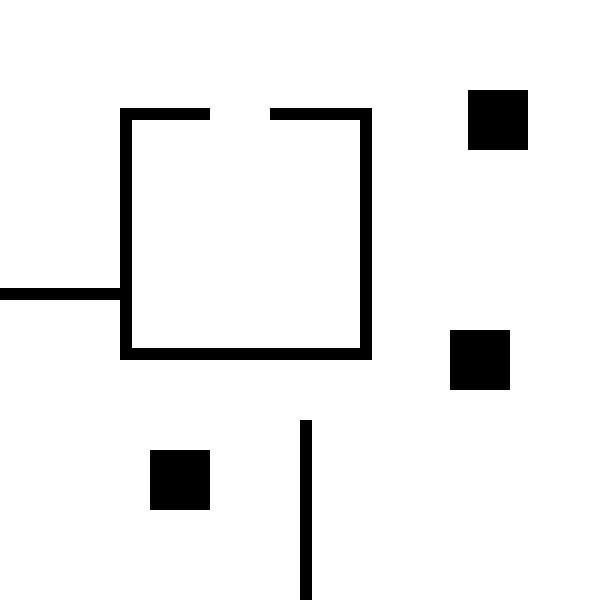

In [614]:
# We visualize the scene below.
visualize() do
    draw_scene(scene)
end

In [615]:
start = Point(0.1, 0.1)
dest = Point(0.5, 0.5)
planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.)
example_path1 = plan_path(start, dest, scene, planner_params)
example_path2 = plan_path(start, dest, scene, planner_params)
example_path3 = plan_path(start, dest, scene, planner_params)

Path(Point[Point(0.1, 0.1), Point(0.3230316711358404, 0.04783513844317932), Point(0.33161230362957017, 0.06164312609434654), Point(0.41485924573197597, 0.3996918042828802), Point(0.6375491288523553, 0.39549344152720967), Point(0.7186049481858776, 0.5892767872524822), Point(0.7259916480816482, 0.8052262710295034), Point(0.6027673662740822, 0.8447541074080748), Point(0.43380748318554785, 0.9227964955058953), Point(0.41968421326401606, 0.8643007115618149), Point(0.5, 0.5)])

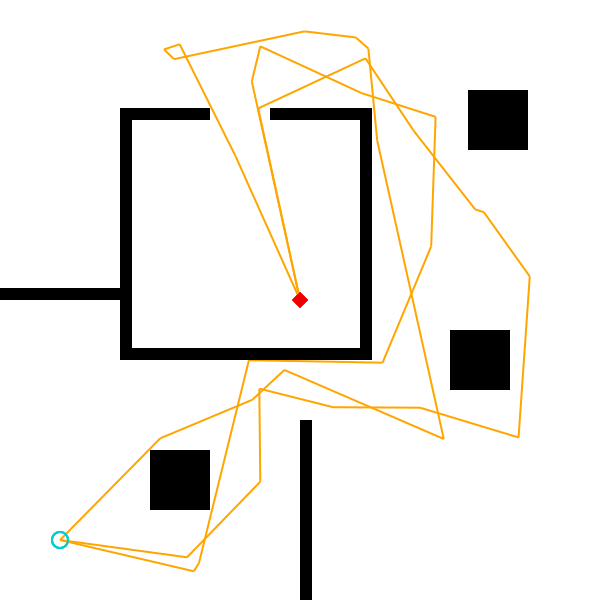

In [616]:
visualize() do
    draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path1.points);
               should_draw_measurements=false)
        draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path2.points);
               should_draw_measurements=false)
        draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path3.points);
               should_draw_measurements=false)
end

In [617]:
speed = 1.
dt = 0.1
num_ticks = 10;
example_locations = walk_path(example_path1, speed, dt, num_ticks)
println(example_locations)

Point[Point(0.1, 0.1), Point(0.19908296443291162, 0.0864882954744276), Point(0.2981659288658232, 0.07297659094885518), Point(0.37177145526961, 0.13316125683960373), Point(0.43371239186115657, 0.2080301881126776), Point(0.43266107111831087, 0.3080246615834432), Point(0.4863107964840555, 0.3385918626984675), Point(0.5841692670169197, 0.32115494869162536), Point(0.6841676531753766, 0.32058682396576466), Point(0.7805701010494935, 0.2961705700579004)]


In [618]:
@gen function walk_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x ~ uniform(0, 1)
    dest_y ~ uniform(0, 1)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.02
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

In [619]:
@gen function chase_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    restaurant ~ categorical([1/2, 1/2])
    dest_x ~ normal(max(0.1, min(0.9, restaurant - 1)), 0.05)
    dest_y ~ normal(max(0.1, min(0.9, 2 - restaurant)), 0.05)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.02
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

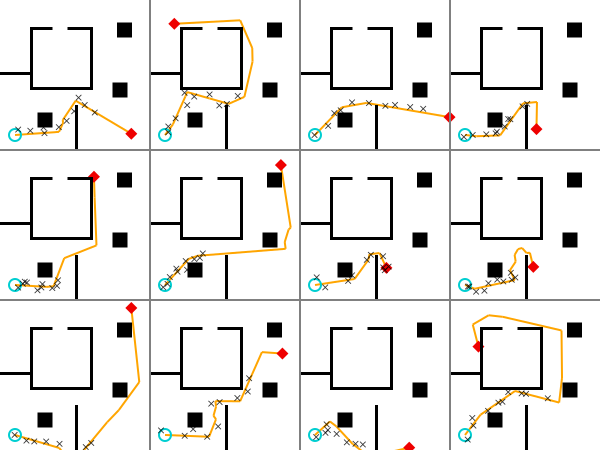

In [620]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1

traces = [Gen.generate(
    walk_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

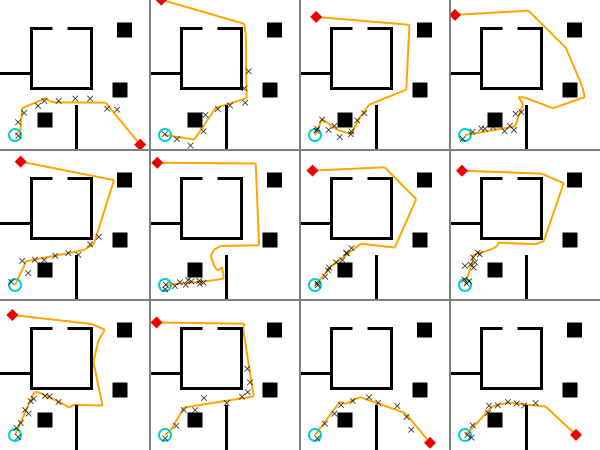

In [621]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1

traces = [Gen.generate(
    chase_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

In [622]:
measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

In [623]:
function do_inference(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams, 
        start::Point, measurements::Vector{Point}, amount_of_computation::Int, model=walk_model)
    
    # Constrain the observed measurements.
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    trace, = importance_resampling(model, (scene, dt, num_ticks, planner_params), observations, amount_of_computation)
    
    return trace
end;

In [624]:
function visualize_inference(measurements, scene, start; computation_amt=50, samples=1000, num_ticks=num_ticks, draw_measurements=true, draw_path=false, model=walk_model)
    visualize() do
        for i in 1:samples
            trace = do_inference(scene, dt, num_ticks, planner_params, start, measurements, computation_amt, model)
            draw_trace(trace; draw_measurements=draw_measurements, draw_path=draw_path)
        end
    end
end;

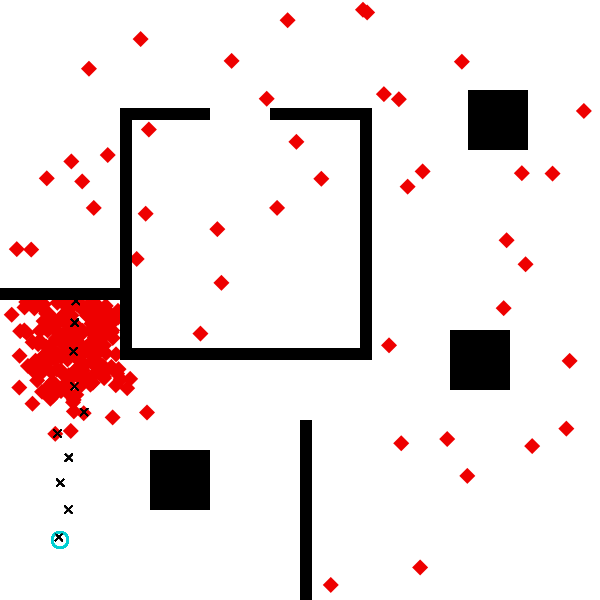

In [625]:
visualize_inference(
    measurements, scene, start, computation_amt=100, samples=250, model=walk_model)

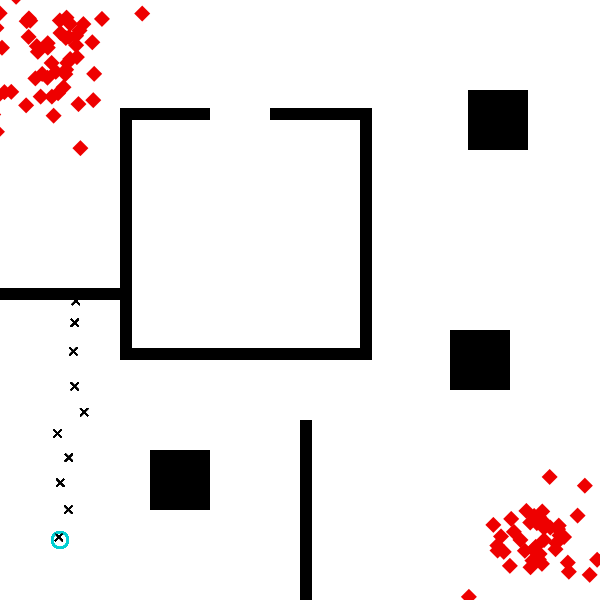

In [626]:
visualize_inference(
    measurements, scene, start, computation_amt=70, samples=100, model=chase_model)

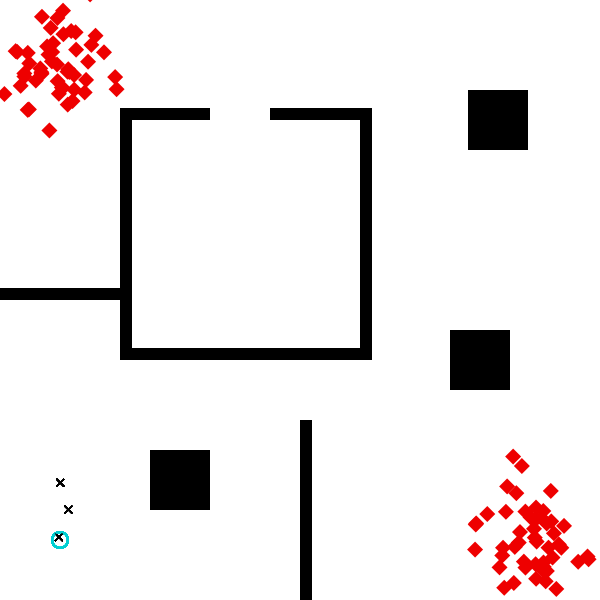

In [627]:
visualize_inference(
    measurements[1:3], scene, start, computation_amt=70, samples=100, num_ticks=3, model=chase_model)

In [628]:
chased_measurements = [
    Point(0.0980245, 0.104775),
    Point(0.148734, 0.150773),
    Point(0.170412, 0.169499),
    Point(0.204794, 0.21000),
    Point(0.2257668, 0.227711),
    Point(0.240181, 0.24304),
    Point(0.274384, 0.276242),
    Point(0.302272, 0.314463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

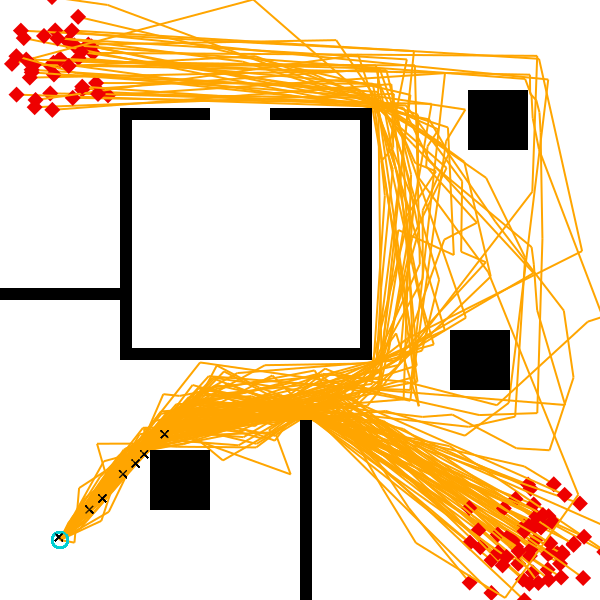

In [629]:
visualize_inference(
    chased_measurements[1:7], scene, start, computation_amt=50, samples=100, draw_path=true, num_ticks=7, model=chase_model)

In [630]:
scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.50, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.60), 0.50, wall_thickness));
add_obstacle!(scene, make_line(vertical, Point(0.70, 0.40), 0.05, wall_thickness));
add_obstacle!(scene, make_line(vertical, Point(0.70, 0.57), 0.05, wall_thickness));

add_obstacle!(scene, make_line(vertical, Point(0.20, 0.60), 0.10, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.70), 0.10, wall_thickness));

add_obstacle!(scene, make_line(vertical, Point(0.20, 0.30), 0.10, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.30), 0.10, wall_thickness));


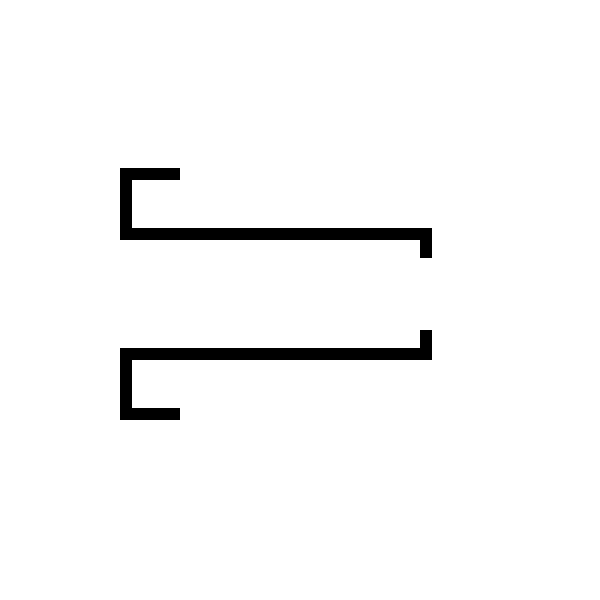

In [631]:
# We visualize the scene below.
visualize() do
    draw_scene(restaurant_scene)
end

In [632]:
start = Point(0.5, 0.5)
dest = Point(0.5, 0.1)
planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.)
example_path1 = plan_path(start, dest, scene, planner_params)
example_path2 = plan_path(start, dest, scene, planner_params)
example_path3 = plan_path(start, dest, scene, planner_params)

Path(Point[Point(0.5, 0.5), Point(0.7964089904974742, 0.4637023361811362), Point(0.5, 0.1)])

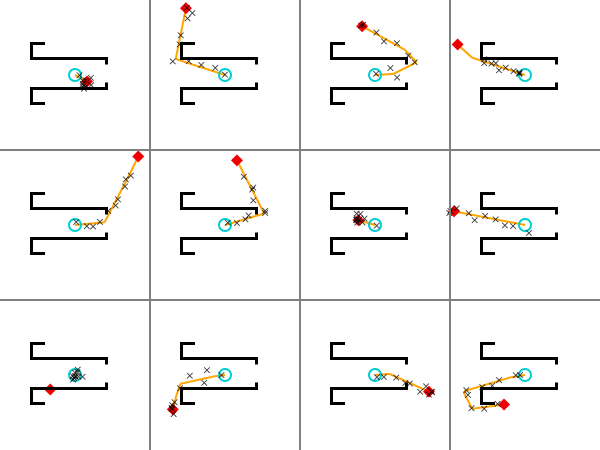

In [633]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.5
constraints[:start_y] = 0.5

traces = [Gen.generate(
    walk_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

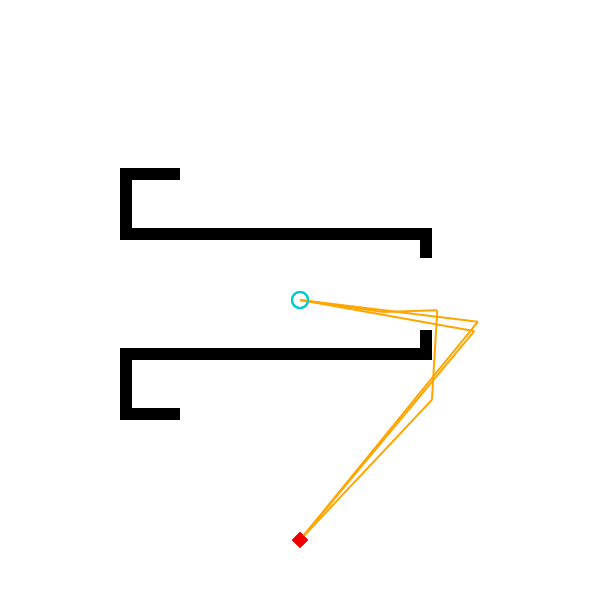

In [634]:
visualize() do
    draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path1.points);
               should_draw_measurements=false)
        draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path2.points);
               should_draw_measurements=false)
        draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path3.points);
               should_draw_measurements=false)
end

In [680]:
@gen function restaurant_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    restaurant ~ categorical([1/3, 1/3, 1/3])
    dest_xs = [0.25, 0.25, 0.9]
    dest_ys = [0.65, 0.35, 0.9]
    dest_x ~ normal(dest_xs[restaurant], 0.0125)
    dest_y ~ normal(dest_ys[restaurant], 0.0125)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.02
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

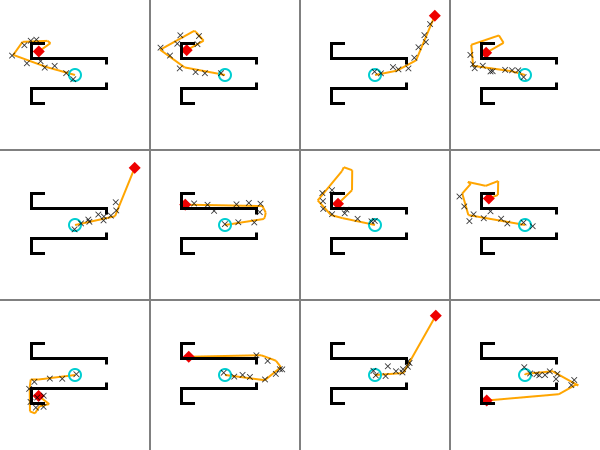

In [681]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.5
constraints[:start_y] = 0.5

traces = [Gen.generate(
    restaurant_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

In [682]:
restaurant_measurements = [
    Point(0.5080245, 0.504775),
    Point(0.60734, 0.50773)];

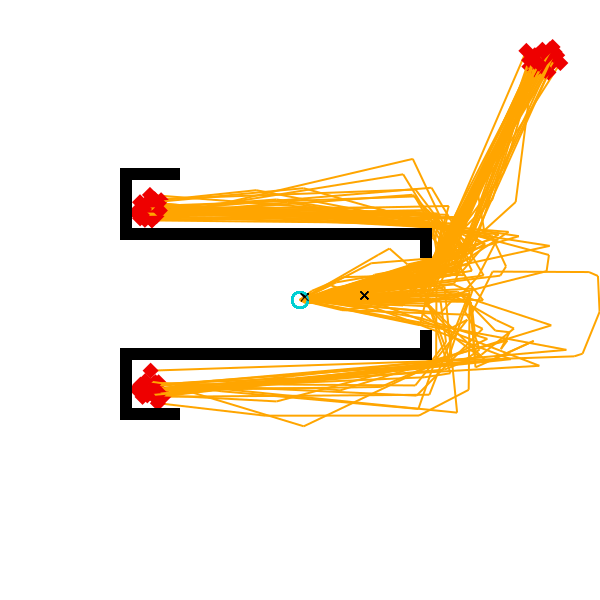

In [683]:
visualize_inference(
    restaurant_measurements, scene, start, computation_amt=50, samples=100, draw_path=true, num_ticks=2, model=restaurant_model)

In [684]:
restaurant_measurements = [
    Point(0.5080245, 0.504775),
    Point(0.40734, 0.50773)];

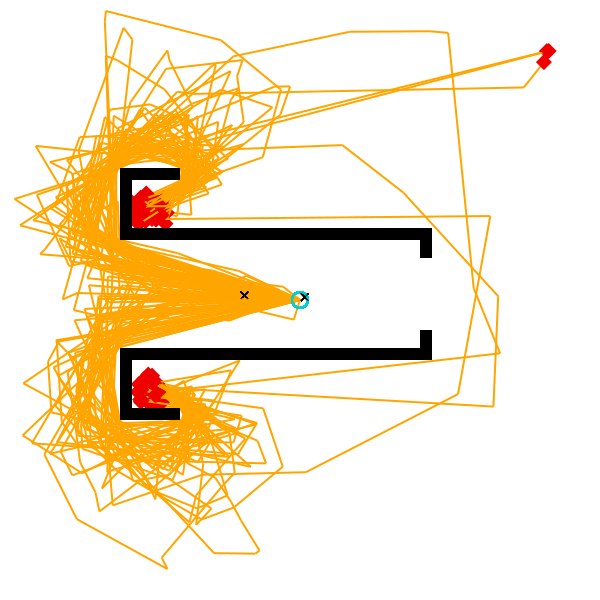

In [685]:
visualize_inference(
    restaurant_measurements, scene, start, computation_amt=50, samples=100, draw_path=true, num_ticks=2, model=restaurant_model)

## Statistical Analysis

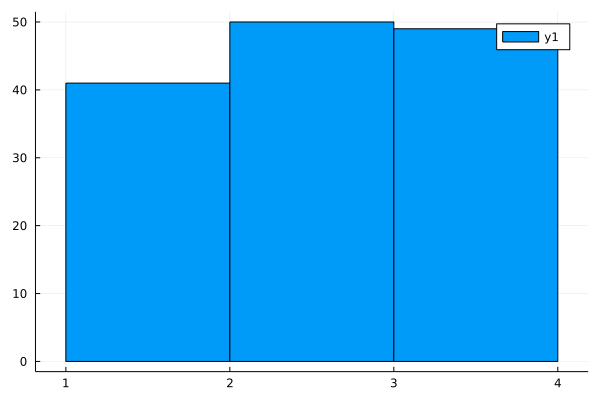

In [637]:
@df data plot(:RestaurantChoice, seriestype=:histogram)

In [638]:
visits = zeros(Int, 3)

for i in 1:3
    visits[i] = sum(data.RestaurantChoice .== i)
end
visits

3-element Vector{Int64}:
 41
 50
 49

In [639]:
@gen function visit_model(prices)
    
    intercept ~ normal(30,30)
    
    price_slope ~ normal(0,15)

    noise ~ gamma(1,1)
    
    
    function f(price)
        return intercept + price * price_slope
    end
    
    for (i,p) in enumerate(prices)
        {(:visits, i)} ~ normal(f(p), noise)
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##visit_model#461", Bool[0], false)

In [640]:
# visits = [30,40,70]

In [641]:
prices = [3., 2.5, 1.]

3-element Vector{Float64}:
 3.0
 2.5
 1.0

In [642]:
test_xs = range(0, 4, length=100)

0.0:0.04040404040404041:4.0

In [643]:
prior_traces = [visit_model([]) for _ in 1:15]

15-element Vector{var"#f#663"{Float64, Float64}}:
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#663"{Float64, Float64}) (generic function with 1 method

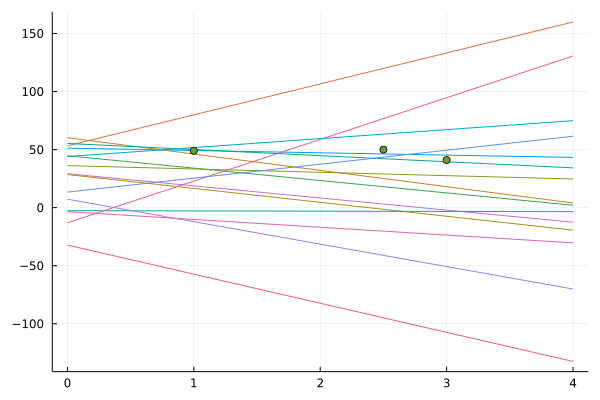

In [644]:
plot(test_xs, [prior_trace.(test_xs) for prior_trace in prior_traces], legend=false)
plot!(prices, visits, seriestype=:scatter)

In [645]:
observations = Gen.choicemap()
for (i,v) in enumerate(visits)
    observations[(:visits, i)] = v
end

traces = [importance_resampling(visit_model,
    (prices,), observations, 50,
    verbose=false)[1] for _ in 1:100]

100-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##visit_model#461", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:price_slope => Gen.ChoiceOrCallRecord{Float64}(-4.058717746789696, -3.6635958226360064, NaN, true), (:visits, 2) => Gen.ChoiceOrCallRecord{Float64}(50.0, -3.0345381504918634, NaN, true), :intercept => Gen.ChoiceOrCallRecord{Float64}(56.595695670313575, -4.713097597193459, NaN, true), (:visits, 3) => Gen.ChoiceOrCallRecord{Float64}(49.0, -3.023886615550064, NaN, true), (:visits, 1) => Gen.ChoiceOrCallRecord{Float64}(41.0, -2.9369471923124673, NaN, true), :noise => Gen.ChoiceOrCallRecord{Float64}(2.167566067187211, -2.167566067187211, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -19.53963144537107, 0.0, ([3.0, 2.5, 1.0],), var"#

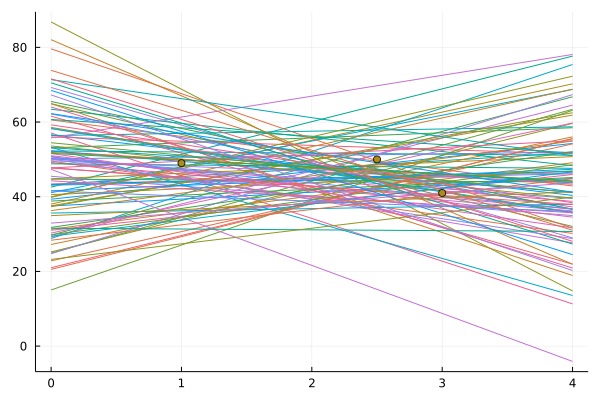

In [646]:
lines = Gen.get_retval.(traces)
plot(test_xs, [f.(test_xs) for f in lines], legend=false)
plot!(prices, visits, seriestype=:scatter)

In [647]:
choices = Gen.get_choices.(traces)
intercepts = Gen.get_value.(choices, :intercept)
price_slopes = Gen.get_value.(choices, :price_slope)
noises = Gen.get_value.(choices, :noise);

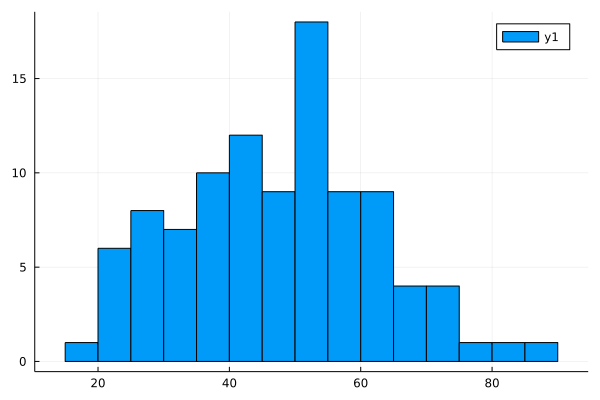

In [648]:
plot(intercepts, bins=25, seriestype=:histogram)

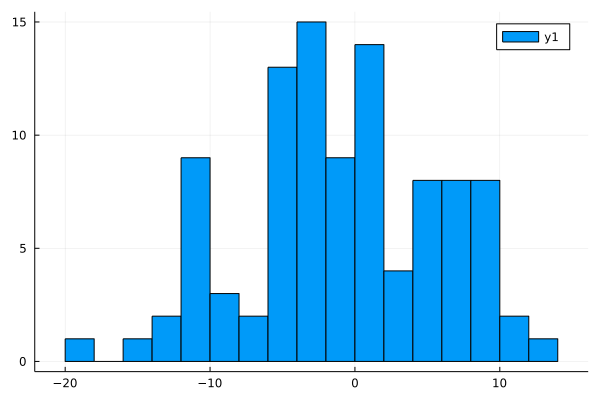

In [649]:
plot(price_slopes, bins=25, seriestype=:histogram)

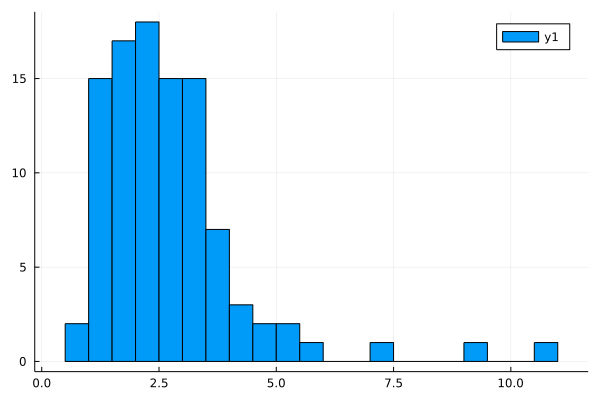

In [650]:
plot(noises, bins=25, seriestype=:histogram)

In [651]:
@gen function visit_full_model(prices, qualities, staff)
    
    intercept ~ normal(30,30)
    
    price_slope ~ normal(0,15)
    quality_slope ~ normal(0,15)
    staff_slope ~ normal(0,15)
    
    noise ~ gamma(1,1)
    
    
    function f(price, quality, staff)
        return intercept + price * price_slope + quality * quality_slope + staff * staff_slope
    end
    
    for (i,p) in enumerate(prices)
        q = qualities[i]
        s = staff[i]
        {(:visits, i)} ~ normal(f(p,q,s), noise)
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##visit_full_model#467", Bool[0, 0, 0], false)

In [652]:
qualities = [0.7, 0.5, 0.7]

3-element Vector{Float64}:
 0.7
 0.5
 0.7

In [653]:
staff = [0.5, 0.2, 1.]

3-element Vector{Float64}:
 0.5
 0.2
 1.0

In [654]:
traces = [importance_resampling(visit_full_model,
    (prices, qualities, staff), observations, 50,
    verbose=false)[1] for _ in 1:100]
lines = Gen.get_retval.(traces)

100-element Vector{var"#f#672"{Float64, Float64, Float64, Float64}}:
 (::var"#f#672"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#672"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#672"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#672"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#672"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#672"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#672"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#672"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#672"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#672"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#672"{Float64, Float64, Float64, Float64}) (generic function 

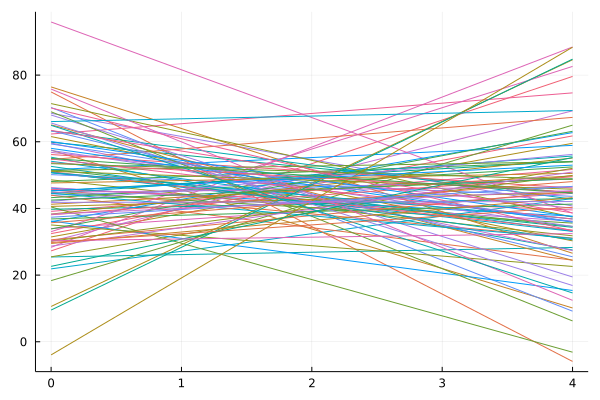

In [655]:
test_xs = range(0, 4, length=100)
plot(test_xs, [f.(test_xs, [0.5 for _ in 1:100], [0.5 for _ in 1:100]) for f in lines], legend=false)

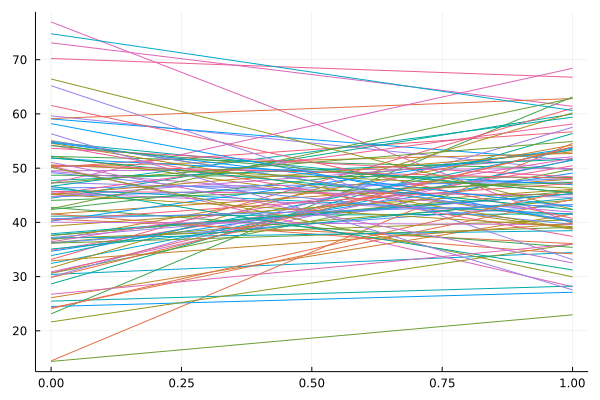

In [656]:
test_xs = range(0,1,length=20)
plot(test_xs, [f.([2 for _ in 1:20], test_xs, [0.5 for _ in 1:20]) for f in lines], legend=false)

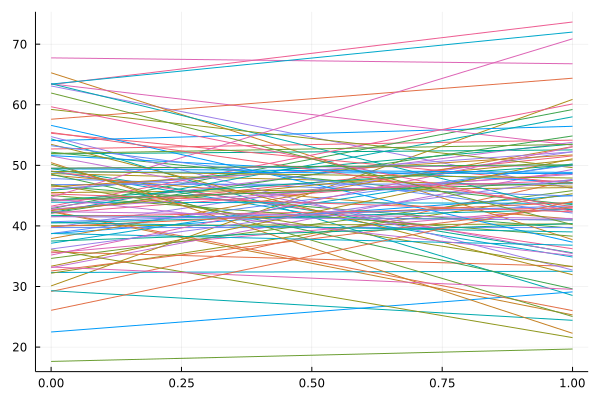

In [657]:
test_xs = range(0,1,length=20)
plot(test_xs, [f.([2 for _ in 1:20], [0.5 for _ in 1:20], test_xs) for f in lines], legend=false)

In [658]:
choices = Gen.get_choices.(traces)
intercepts = Gen.get_value.(choices, :intercept)
price_slopes = Gen.get_value.(choices, :price_slope)
quality_slopes = Gen.get_value.(choices, :quality_slope)
staff_slopes = Gen.get_value.(choices, :staff_slope)
noises = Gen.get_value.(choices, :noise);

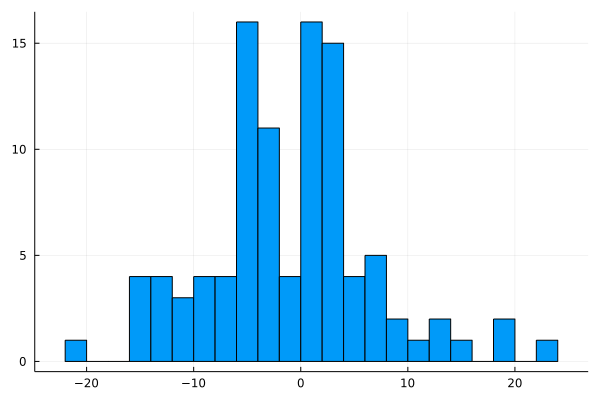

In [659]:
plot(price_slopes, bins=25, seriestype=:histogram, legend=false)

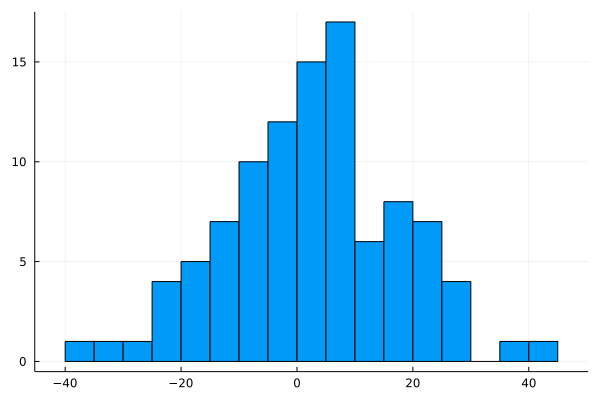

In [660]:
plot(quality_slopes, bins=35, seriestype=:histogram, legend=false)

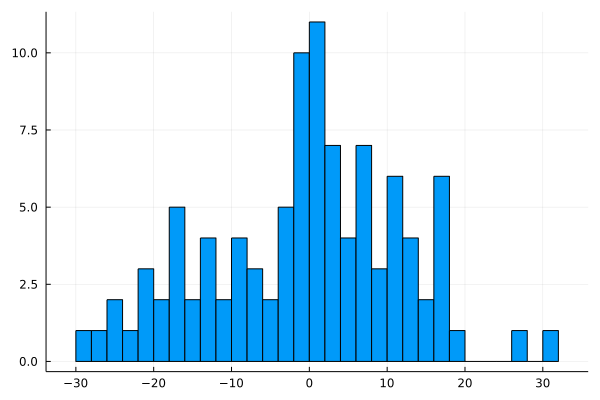

In [661]:
plot(staff_slopes, bins=35, seriestype=:histogram, legend=false)

## Predictive Distribution
https://www.mhnederlof.nl/bayesnormalupdate.html

In [662]:
sample_intercept_mu, sample_intercept_std = mean_and_std(intercepts) 

(45.842124743382755, 18.85086159701382)

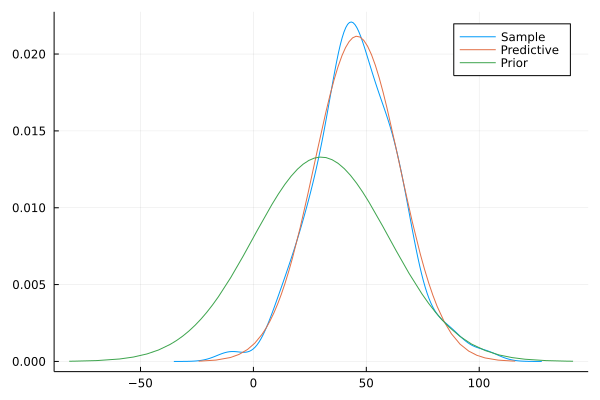

In [663]:
plot(intercepts, seriestype=:density, label="Sample")
plot!(Normal(sample_intercept_mu, sample_intercept_std), label="Predictive")
plot!(Normal(30, 30), label="Prior")

In [664]:
sample_price_slope_mu, sample_price_slope_std = mean_and_std(price_slopes) 

(-0.9767040557427437, 7.652084970188709)

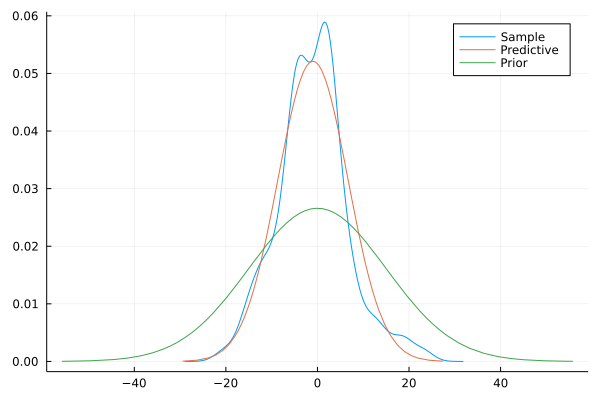

In [665]:
plot(price_slopes, seriestype=:density, label="Sample")
plot!(Normal(sample_price_slope_mu, sample_price_slope_std), label="Predictive")
plot!(Normal(0, 15), label="Prior")

In [666]:
sample_quality_slope_mu, sample_quality_slope_std = mean_and_std(quality_slopes)

(2.5431987778571887, 14.934161171001467)

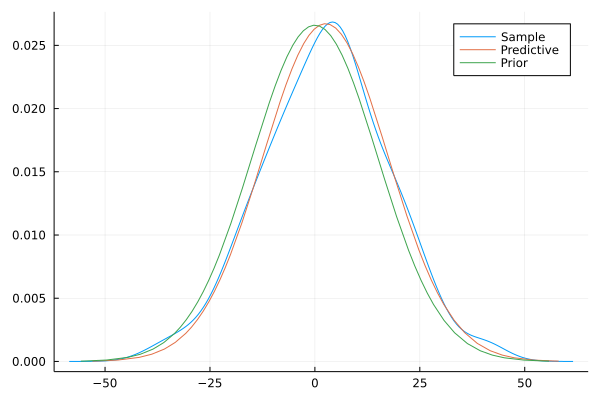

In [667]:
plot(quality_slopes, seriestype=:density, label="Sample")
plot!(Normal(sample_quality_slope_mu, sample_quality_slope_std), label="Predictive")
plot!(Normal(0, 15), label="Prior")

In [668]:
sample_staff_slope_mu, sample_staff_slope_std = mean_and_std(staff_slopes)

(-0.6022520698618075, 12.3183084644674)

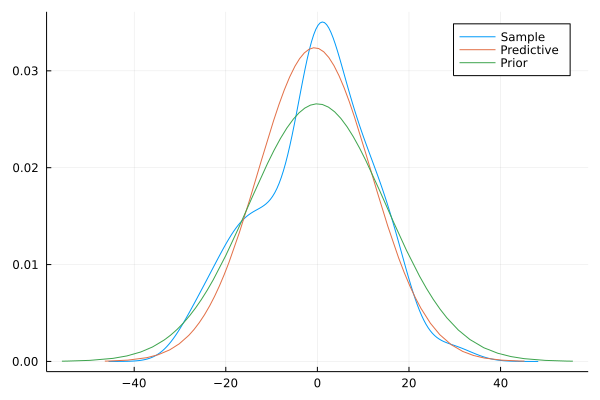

In [669]:
plot(staff_slopes, seriestype=:density, label="Sample")
plot!(Normal(sample_staff_slope_mu, sample_staff_slope_std), label="Predictive")
plot!(Normal(0, 15), label="Prior")

In [670]:
sample_noises_mu, sample_noises_std = mean_and_std(noises)

(2.8030269090144, 1.3616720682709385)

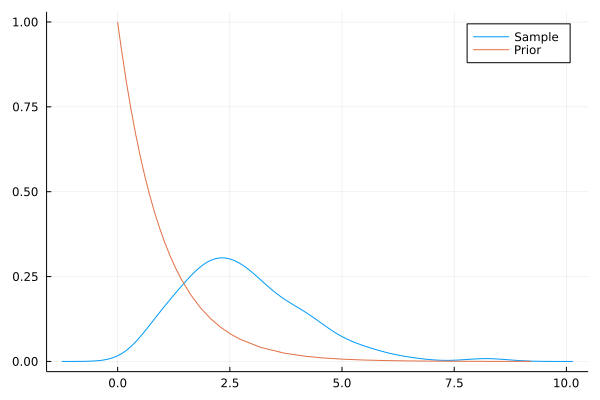

In [671]:
plot(noises, seriestype=:density, label="Sample")
# plot!(Normal(sample_noises_mu, sample_noises_std), label="Predictive")
plot!(Gamma(1, 1), label="Prior")